# Mergers Rates in a Primordial Black Hole Cluster

#### Code Writed by Tadeo D.
##### Dedicated to the Moon of my life; universe of my soul. 

**References:** [arXiv:2105.14523](https://arxiv.org/pdf/2105.14523.pdf). [arXiv:1603.05234](https://arxiv.org/pdf/1603.05234.pdf)

In [1]:
import numpy as np
import matplotlib.pyplot as pl
import matplotlib as mpl
import math
import seaborn as sns
from scipy import stats
from astropy import constants as const
import csv
from scipy import constants
from scipy.integrate import odeint
from tqdm import tqdm
from scipy import integrate
from scipy.integrate import quad, dblquad
from astropy.cosmology import Planck18 as cosmo# WMAP9 as cosmo #
import astropy.units as u
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sympy import *
from sympy import simplify
import pandas as pd
import os
import errno
from itertools import combinations, permutations

### BASIC CONTANST TO COSMOLOGY

$$ H_{0} = 67.66 \frac{km}{Mpc\:\:s}$$
$$ G = 6.6743 \times 10^{-11} \frac{m^{3}}{kg\:\:s^{2}} $$ \
$$ c = 299792458.0 \: \frac{m}{s}$$

In [2]:
H0 = cosmo.H(0)
G = const.G
c = const.c

## Cluster Propierities to 1st Generation (Boundary Conditions)

$M $ is the total mass of the cluster in $M_{\odot}$ \
$R $ Scale factor that determines the core radius in  $pc$


The characteristic velocity of the PBHs give by $$v_{rel} = \left(\frac{G\:M}{R}\right)^{1/2}$$ 

$m_{i}$ \& $m_{j}$ are the mass from two diferent species objetcs into cluster (to this model booth species are PBHs) 


#### Conditional step to compare masses from $m_{i}$ and $m_{j}$

##### $m_{i}$ = $m_{j}$ :

$$N_{i,j} = \frac{M}{2\:m_{i,j}}$$ 

##### $m_{j}$ > $m_{i}$ :

$$\zeta = \frac{m_j}{m_i}$$

$$N_{i} = \frac{M}{\zeta\:m_{i}}$$\
$$N_{j} = N_{i} - \frac{M}{\zeta\:m_{j}}$$ 

##### $m_{i}$ > $m_{j}$ :

$$\zeta = \frac{m_i}{m_j}$$

$$N_{j} = \frac{M}{\zeta\:m_{j}}$$\
$$N_{i} = N_{j} - \frac{M}{\zeta\:m_{i}}$$

$N_{i}$ Number of PBHs of Mass $m_{i}$, in the same way $N_{j}$, so: $$N_{i} + N_{j} = N_{tot}$$


#### Obtain total Mass from every specie into Cluster:

At time to get each value to $N_{i}$ and $N_{j}$ only make a simple multiplication:

$$M_{i} = (N_i)(m_i)$$
$$M_{j} = (N_j)(m_j)$$

In [3]:
M = 10**5 * u.M_sun
R = .9*u.parsec
v_rel = (G*M/R)**(1./2.)
m_i = 30.*u.M_sun
m_j = 30.*u.M_sun

if m_i==m_j:
    N_i = M/(2*m_i)
    N_j = M/(2*m_j)
if m_j>m_i:
    zetha = (m_j/m_i)
    N_i = (M/(zetha*m_i))
    N_j =  N_i - (M/(zetha*m_j))
if m_i>m_j:
    zetha = (m_i/m_j)
    N_j = (M/(zetha*m_j))
    N_i = N_j - (M/(zetha*m_i))

M_i = (N_i*m_i)
M_j = (N_j*m_j)
    
print("Cluster Propierities\n")
print("M =\t", M)
print("R =\t", R)
print("m_i =\t", m_i, "\t\t N_i =\t", round(float(N_i)))
print("m_j =\t", m_j, "\t\t N_j =\t", round(float(N_j)))
#print("M_t = ", (M_i + M_j))
print("\t\t\t\t N_total =\t",round(float(N_i + N_j)))
print("v_rel =\t", "{:.2f}".format(v_rel.to(u.km* u.s**(-1))))

Cluster Propierities

M =	 100000.0 solMass
R =	 0.9 pc
m_i =	 30.0 solMass 		 N_i =	 1667
m_j =	 30.0 solMass 		 N_j =	 1667
				 N_total =	 3333
v_rel =	 21.86 km / s


## Plummer Model

###### For convenience we choose the initial cluster configuration to be a Plummer model:


$$f_{i,j}(E) = \frac{24\sqrt{2}N_{i,j}R^{2}E_{i,j}^{7/2}}{7\pi^{3} G^{5}M^{5}}$$

$$\rho_{i,j}(r) = \frac{3\:M_{i,j}}{4\pi\:R^{3}}\left(1 + \frac{r^{2}}{R^{2}}\right)^{-5/2}$$

$$\phi(r) = 2v_{rms}(r)^{2} = \frac{G\:M}{R}\left(1 + \frac{r^{2}}{R^{2}}\right)^{-1/2}$$

In [4]:
def f_i(E_i): ## eq. 19 shapiro
    return (24. * (2.)**(1./2.) * N_i * R**2. * E_i**(7./2.))/(7*(math.pi**(3.))*(G**5.)*(M**5.))

def f_j(E_j):
    return (24. * (2.)**(1./2.) * N_j * R**2. * E_j**(7./2.))/(7*(math.pi**(3.))*(G**5.)*(M**5.))

def rho_i(r):## eq. 20
    return ((3*M_i)/(4*(math.pi)*(R**(3.))))*((1 + r**(2.)/R**(2.))**(-5./2.))

def rho_j(r):
    return ((3*M_j)/(4*(math.pi)*(R**(3.))))*((1 + r**(2.)/R**(2.))**(-5./2.))

def phi(r):## eq. 21
    return (G*M/R)*((1 + r**(2.)/R**(2.))**(-1./2.))

## According to the virial theorem, the total energy is $E = \frac{G(m\:N)^{2}}{2\:R}$

Total energy to specie $m_{i}$:

$$E_{it} = \frac{G(m_{i}\:N)^{2}}{2\:R}$$

Total energy to specie $m_{j}$:
$$E_{jt} = \frac{G(m_{j}\:N)^{2}}{2\:R}$$

In [5]:
Energy_it = G*((m_i*N_i)**(2.))/((2*R)*(1*u.M_sun))
print("E_i =\t", Energy_it.to(u.parsec**2.*u.s**(-2.)))

Energy_jt = G*((m_j*N_j)**(2.))/((2*R)*(1*u.M_sun))
print("E_j =\t", Energy_jt.to(u.parsec**2.*u.s**(-2.)))

E_i =	 6.2737542359652286e-21 pc2 / s2
E_j =	 6.2737542359652286e-21 pc2 / s2


## Compute the mean-squared velocity

$$\overline{v_{i,j}^{2}}(r) = \frac{4\:\pi}{n_{i,j}(r)}\int_{0}^{\phi(r)}\;f_{i,j}(E) \left[2(\phi(r)-E)\right]^{3/2}\;dE$$

$$n_{i,j}(r) = \frac{\rho_{i,j}(r)}{m_{i,j}}$$


$$\overline{v_{i,j}^{2}}(r) = \frac{4\pi\:m_{i,j}}{\rho_{i,j}(r)} \frac{24\sqrt{2}N_{i,j}R^{2}}{7\pi^{3} G^{5}M^{5}} \int_{0}^{\phi(r)} \: E_{i,j}^{7/2} \left[2(\phi(r)-E)\right]^{3/2} \; dE$$

$$\overline{v_{i,j}^{2}}(r) = \left(\frac{4\pi\:m_{i,j}}{\rho_{i,j}(r)} \frac{24\sqrt{2}N_{i,j}R^{2}}{7\pi^{3} G^{5}M^{5}}\right)\left(\frac{7\pi\phi^{6}(r)}{2^{17/2}}\right)$$

$$\overline{v_{i,j}}(r) = \left(\frac{(4)(24)\sqrt{2}N_{i,j}R^{2}}{\pi G^{5}M^{5}2^{17/2}}\right)^{1/2} \left[\frac{\phi^{3}(r)}{n^{1/2}_{i,j}(r)}\right] = \alpha^{1/2} N^{1/2}_{i,j} \left[\frac{\phi^{3}(r)}{n^{1/2}_{i,j}(r)}\right]$$

Using $\alpha = \left(\frac{(4)(24)\sqrt{2}R^{2}}{\pi G^{5}M^{5}2^{17/2}}\right) $

In [6]:
def n_i_1(r):
    return (rho_i(r)/m_i)

def n_j_1(r):
    return (rho_j(r)/m_j)
    
alfa = ((4*24*(2**(1/2))*(R**(2.)))/(math.pi*(G**(5.))*(M**(5.))*(2**(17./2.))))

def vel_i(r):
    return (alfa**(1./2.))*(N_i**(1./2.))*((phi(r)**(3))/(n_i_1(r)**(1./2.)))

def vel_j(r):
    return (alfa**(1./2.))*(N_j**(1./2.))*((phi(r)**(3))/(n_j_1(r)**(1./2.)))

$$\Gamma_{j} = \frac{14 \pi}{3} \sum_{i}\sigma(m_{j},m_{i})\int\;dr\;r^{2}\frac{n_{j}}{\overline{v}_{j}}\frac{n_{i}}{\overline{v}_{i}} \left[(\overline{v}_{j} + \overline{v}_{i})^{3/7} - |\bar{v}_{j} - \bar{v}_{i}|^{3/7}\right] $$

Using equations from plummer model, we rewrite for each specie:

$$\overline{v_{i}}(r_{1}) = \alpha^{1/2} N^{1/2}_{i} \left[\frac{\phi^{3}(r_{1})}{n^{1/2}_{i}(r_{1})}\right] \;\;\;\;\;\;\;\;\rho_{i}(r_{1}) = \frac{3\:M_{i}}{4\pi\:R^{3}}\left(1 + \frac{r^{2}_{1}}{R^{2}}\right)^{-5/2}$$

$$\overline{v_{j}}(r_{0}) = \alpha^{1/2} N^{1/2}_{j} \left[\frac{\phi^{3}(r_{0})}{n^{1/2}_{j}(r_{0})}\right] \;\;\;\;\;\;\;\; \rho_{j}(r_{0}) = \frac{3\:M_{j}}{4\pi\:R^{3}}\left(1 + \frac{r^{2}_{0}}{R^{2}}\right)^{-5/2}$$

$$n_{i}(r_{1}) = \frac{\rho_{i}(r_{1})}{m_{i}} = \frac{3\:M_{i}}{4\pi\:m_{i}\:R^{3}}\left(1 + \frac{r^{2}_{1}}{R^{2}}\right)^{-5/2} =  \beta\;N_{i}(1+a)^{-5/2}$$

$$n_{j}(r_{0}) = \frac{\rho_{j}(r_{0})}{m_{j}} = \frac{3\:M_{j}}{4\pi\:m_{i}\:R^{3}}\left(1 + \frac{r^{2}_{0}}{R^{2}}\right)^{-5/2} =  \beta\;N_{j}(1+b)^{-5/2}$$

Using: $\beta = \frac{3}{4\pi R^{3}}$ and $a=\frac{r_{1}^{2}}{R^{2}}$, $b=\frac{r_{0}^{2}}{R^{2}}$

$$\phi(r_{1}) = 2v_{rms}(r_{1})^{2} = \frac{G\:M}{R}\left(1 + \frac{r^{2}_{1}}{R^{2}}\right)^{-1/2} = \eta\:\left(1 + a\right)^{-1/2} $$

$$\phi(r_{0}) = 2v_{rms}(r_{0})^{2} = \frac{G\:M}{R}\left(1 + \frac{r^{2}_{0}}{R^{2}}\right)^{-1/2} = \eta\:\left(1 + b\right)^{-1/2} $$

Using: $\eta = \frac{GM}{R}$

$\Rightarrow$

$$\frac{n_{i}(r_{1})}{\overline{v_{i}}(r_{1})} = n_{i}(r_{1})\left(\alpha^{-1/2} N^{-1/2}_{i} \left[\frac{n^{1/2}_{i}(r_{1})}{\phi^{3}(r_{1})}\right]\right) = \left(\alpha^{-1/2} N^{-1/2}_{i} \left[\frac{n^{3/2}_{i}(r_{1})}{\phi^{3}(r_{1})}\right]\right) $$

$$n^{3/2}_{i}(r_{1}) = \beta^{3/2} N^{3/2}_{i}(1+a)^{-15/4}$$

$$\phi^{3}(r_{1}) = \eta^{3}\:\left(1 + a\right)^{-3/2} $$

$\Rightarrow$

$$\frac{n^{3/2}_{i}(r_{1})}{\phi^{3}(r_{1})} = \frac{\beta^{3/2} N^{3/2}_{i}(1+a)^{-15/4}}{\eta^{3}\:\left(1 + a\right)^{-3/2}} = \beta^{3/2} \eta^{-3} N^{3/2}_{i}(1+a)^{-9/4} $$

$\Rightarrow$

$$\frac{n_{i}(r_{1})}{\overline{v_{i}}(r_{1})} = \alpha^{-1/2} N^{-1/2}_{i} \left( \beta^{3/2} \eta^{-3} N^{3/2}_{i}(1+a)^{-9/4} \right) = \alpha^{-1/2} \beta^{3/2} \eta^{-3} N_{i}(1+a)^{-9/4}$$

Analogically $\frac{n_{j}(r_{0})}{\bar{v_{j}}(r_{0})} = \alpha^{-1/2} \beta^{3/2} \eta^{-3} N_{j}(1+b)^{-9/4}$

In another hand:

$(\overline{v}_{j} + \overline{v}_{i})^{3/7} = \left[\alpha^{1/2} N^{1/2}_{j} \left(\frac{\phi^{3}(r_{0})}{n^{1/2}_{j}(r_{0})}\right) + \alpha^{1/2} N^{1/2}_{i} \left(\frac{\phi^{3}(r_{1})}{n^{1/2}_{i}(r_{1})}\right)\right]^{3/7} = \alpha^{3/14} \left[N^{1/2}_{j} \left(\frac{\phi^{3}(r_{0})}{n^{1/2}_{j}(r_{0})}\right) + N^{1/2}_{i} \left(\frac{\phi^{3}(r_{1})}{n^{1/2}_{i}(r_{1})}\right)\right]^{3/7}$

$$(\overline{v}_{j} + \overline{v}_{i})^{3/7} = \alpha^{3/14} \left[N^{1/2}_{j}\left(\frac{\eta^{3}\:(1 + b)^{-3/2}}{\beta^{1/2}\;N_{j}^{1/2}(1+b)^{-5/4}}\right) + N^{1/2}_{i}\left(\frac{\eta^{3}\:(1 + a)^{-3/2}}{\beta^{1/2}\;N_{i}^{1/2}(1+a)^{-5/4}}\right) \right]^{3/7} $$

$$= \frac{\alpha^{3/14}\eta^{9/7}}{\beta^{3/14}} \left[\left(\frac{(1 + b)^{-3/2}}{(1+b)^{-5/4}}\right) + \left(\frac{(1 + a)^{-3/2}}{(1+a)^{-5/4}}\right) \right]^{3/7} $$

$$=\frac{\alpha^{3/14}\eta^{9/7}}{\beta^{3/14}} \left[\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right) \right]^{3/7}$$

Analogically $|\overline{v}_{j} + \overline{v}_{i}|^{3/7}$. Substituting in $\Gamma$

$\Rightarrow$

$\Gamma_{j} = \frac{14 \pi}{3} \sum_{i}\sigma(m_{j},m_{i})\frac{n_j(r_{0})}{\overline{v_{j}}(r_{0})} \int\;dr_{1} r^{2}_{1} \alpha^{-1/2} \beta^{3/2} \eta^{-3} N_{i}(1+a)^{-9/4} \left[\frac{\alpha^{3/14}\eta^{9/7}}{\beta^{3/14}} \left[\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right) \right]^{3/7} - \left|\frac{\alpha^{3/14}\eta^{9/7}}{\beta^{3/14}} \left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right)\right|^{3/7}\right]$

$=\frac{14 \pi}{3} \sum_{i}\sigma(m_{j},m_{i})\frac{n_j(r_{0})}{\overline{v_{j}}(r_{0})} \alpha^{-2/7} \beta^{9/7} \eta^{-12/7} N_{i} \int\;dr_{1} r^{2}_{1} (1+a)^{-9/4} \left[\left[\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right) \right]^{3/7} - \left|\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right)\right|^{3/7}\right]$

$$\Gamma = \int\;dr_{1}\;r^{2}_{1} (1+a)^{-9/4} \left[\left[\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right) \right]^{3/7} - \left|\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right)\right|^{3/7}\right]$$

In [7]:
def GAMMA(r1,r0):
    a=(r1**(2.)/((R.value)**(2.)))
    b=(r0**(2.)/(R**(2.)))
    return (r1**(2.))*((1.+(a))**(-9./4.))*(1./((1. + b)**(1./4.)) + 1./((1. + a)**(1./4.)))**(3./7.) - abs((1./((1. + b)**(1./4.)) - 1./((1. + a)**(1./4.))))**(3./7.)

### The merger cross-section of two PBHs with masses $m_{i}$ and $m_{j}$
$$\sigma=2 \pi \left(\frac{85\pi}{6\sqrt{2}}\right)^{2/7}\frac{G^{2}(m_{i} +  m_{j})^{10/7}m_{i}^{2/7}m_{j}^{2/7}}{c^{10/7}|v_{j}-v_{i}|^{18/7}}$$

$$\sum_{i}\sigma(m_{j},m_{i})=2 \pi \left(\frac{85\pi}{6\sqrt{2}}\right)^{2/7}\frac{G^{2}(m_{i} +  m_{j})^{10/7}m_{i}^{2/7}m_{j}^{2/7}}{c^{10/7}}$$

In [8]:
sigma = 2*math.pi*(85*math.pi/(6*math.sqrt(2)))**(2./7.) * (G**(2.) * (m_i+m_j)**(10./7.) * m_i**(2./7.) * m_j**(2./7.))/(c**(10./7.))
sigma = sigma.to(u.m**(32./7)/u.s**(18./7.))#.to(u.parsec**2)
print(sigma)

5.578491718089441e+32 m(32/7) / s(18/7)


### Constants to integral

$$ctes = \frac{14 \pi}{3} \sum_{i}\sigma(m_{j},m_{i})\frac{n_j(r_{0})}{\overline{v_{j}}(r_{0})} \alpha^{-2/7} \beta^{9/7} \eta^{-12/7} N_{i}$$

In [9]:
betha = (3./(4*math.pi*(R**(3.))))
etha = (G*M/R)

### Interval to evaluate

$$r = \left[0.1, R\right]$$

Note: To use np.arange, define a open right interval. So is neccesary to do R plus interval to get the last one value. This is defined with separation betwen values with variable $interval = 0.1$ (size steps).

In [10]:
interval = 0.1
r = np.arange(.1, R.value+interval, interval)

### Numerical Solution to Integral
$$I, err\; = \;\int_{h+interval}^{0}\;dr_{1}\;r^{2}_{1} (1+a)^{-9/4} \left[\left[\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right) \right]^{3/7} - \left|\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right)\right|^{3/7}\right]$$

Where $I$ is the numerical solution and $err$ is the error range. So the merger rate to the 1st generation is defined by:

$$merger = I*ctes$$

to obtain

Number_Mergers at Universe's time $= merger*(cosmo.age(0))$

Time to the first Merger = $merger^{-1}$

Note: $cosmo.age(0)$ is a function from Astropy library the zero value into represent the redshift $z=0$

In [11]:
print("Primordial Black holes Masses:\t", "m_i = ",m_i,"\t m_j = ", m_j, "\n")
print("radius \t merger_rate \t\t\t Number_Mergers at Universe's time \t Time to the first Merger\n")

colm1 = []
colm2 = []
colm3 = []
colm4 = []

for h in r:
    r0 = h*u.parsec
    colm1.append("%.2f"%r0.value)
    I, err = quad(GAMMA, h+interval, 0., args=(r0,))
    ctes = (14*math.pi/3.)*sigma*(N_i)*(n_j_1(r0)/vel_j(r0))*(alfa**(-2./7.))*(betha**(9./7.))*(etha**(-12./7.))
    merger = (I*ctes*(u.parsec**(3.))).to(u.yr**(-1))
    colm2.append(merger.value)
    colm3.append((merger*(cosmo.age(0).to(u.yr))).value)
    colm4.append(((merger**(-1.)).to(u.Gyr)).value)
    print("%.2f"%r0.value,"\t",merger,"\t\t", merger*(cosmo.age(0).to(u.yr)),"\t\t",(merger**(-1.)).to(u.Gyr))#/(cosmo.age(0).to(u.yr)))


Primordial Black holes Masses:	 m_i =  30.0 solMass 	 m_j =  30.0 solMass 

radius 	 merger_rate 			 Number_Mergers at Universe's time 	 Time to the first Merger

0.10 	 8.059515751267106e-12 1 / yr 		 0.11111561925246019 		 124.07693351089753 Gyr
0.20 	 1.5113567537537483e-11 1 / yr 		 0.20836902214420658 		 66.16571484636606 Gyr
0.30 	 2.1801824678420543e-11 1 / yr 		 0.3005792562159087 		 45.867720466067254 Gyr
0.40 	 2.6746282252499215e-11 1 / yr 		 0.36874792567038456 		 37.388373851717596 Gyr
0.50 	 2.9591064186923895e-11 1 / yr 		 0.40796860790952694 		 33.79398570065263 Gyr
0.60 	 3.057893580817352e-11 1 / yr 		 0.42158828064480586 		 32.7022498844681 Gyr
0.70 	 3.0165595291026736e-11 1 / yr 		 0.4158896023442298 		 33.150348612462714 Gyr
0.80 	 2.8808197494820423e-11 1 / yr 		 0.39717531461873257 		 34.71234186657445 Gyr
0.90 	 2.6884577835657848e-11 1 / yr 		 0.37065459101316717 		 37.19604622817134 Gyr


### Preparing data to 2nd Generation

All data out have been saved into arrays called colm(number):
colm1 = radius value
colm2 = merger rate value
colm3 = Number Merger at universe's time
colm4 = Time to the first merger

Choseen colm4 to do:

1) Compare every data with Universe's time today

2) if time to the first merger < cosmo.age(0)

    2.1) Chose the minimum time to the first merger
    
    2.2) reduce this time divide by 10 # you can change this value to reduce the probability
    
    2.3) save value at delta_t_1 variable; unit in years

3) if time to the first merger > cosmo.age()
    
    3.1) define delta_t_1 = 10e9 years # you can change this value to change the probability

4) Obtain Minimum time to get 1st Generation

In [12]:
for i in colm4:
    if (i/10)<cosmo.age(0).value:
        delta_t_1 = (np.amin(colm4))*u.Gyr
        delta_t_1 = round((delta_t_1/10.).to(u.yr).value)
    else:
        delta_t_1 = (10e9)
        #print("To get mergers we need age of universe, the system going to use")
        #print("{:.2e}".format(delta_t_1))
            
print("Minimum time to get 1st Generation: \n T_merger = ","{:.2e}".format(delta_t_1)*u.yr)

Minimum time to get 1st Generation: 
 T_merger =  3.27e+09 yr


## Probability and Collision Number

#### Probability :
We defined the probability by:

$$Prob = \int_{t_{0}}^{t}\Gamma dt_{1}$$

So to every each value to merger rate from colm2:

$$\Gamma_{value} = merger_{value}$$

$$P = (\Gamma_{value}){\Delta t_{1}}$$

#### Collision number:

$$\int_{0}^{i+interval} n_{i}(r_{1}) dV = \int_{0}^{i+interval} \beta\;N_{i}(1+a)^{-5/2} \;dV $$

$\beta = \frac{3}{4\pi R^{3}}$

$$N_{i}(r_{1})=\frac{3N_{i}}{R^{3}}\int_{0}^{i+interval}\frac{r_{1}^{2}\;dr_{1}}{(1+a)^{5/2}}$$

Analogically

$$N_{j}(r_{0})=\frac{3N_{j}}{R^{3}}\int_{0}^{i+interval}\frac{r_{0}^{2}\;dr_{0}}{(1+b)^{5/2}}$$

To get the collision number only we need to do:

$$Num_{col} = N_{j}(r_{0}) Prob $$

In [13]:
number_col_array = []
prob_array = []
print("Primordial Black holes Masses:\t", "m_i = ",m_i,"\t m_j = ", m_j,  "\n")
print("Merger_Rate \t\t\t | Probability \t\t | Collision Number \t |")
print("----------------------------------------------------------------------------------")

def integrand_n_i(r1):
    a=(r1**(2.)/((R.value)**(2.)))
    return (r1**(2.))*((1 + a)**(-5./2.))

def integrand_n_j(r0):
    b=(r0**(2.)/((R.value)**(2.)))
    return (r0**(2.))*((1 + b)**(-5./2.))

for h,i in zip(colm2, r):
    GAMMA_value = h*(1/u.yr)
    Prob = GAMMA_value*(delta_t_1*u.yr) #integration dt
    prob_array.append(Prob)
    #I, err = quad(integrand_n_i, 0 , i+interval)
    #N_j_r = betha*N_j*I*u.parsec**3.
    I, err = quad(integrand_n_j, 0 , i+interval)
    N_j_r = 3*N_j*(R**(-3.))*I*u.parsec**3.
    Num_Col = N_j_r*Prob #numero de choques
    #Num_Col = N_j*Prob
    number_col_array.append(Num_Col)
    print(GAMMA_value, " \t | " , Prob, " \t\t |" , Num_Col, " \t | ")

Primordial Black holes Masses:	 m_i =  30.0 solMass 	 m_j =  30.0 solMass 

Merger_Rate 			 | Probability 		 | Collision Number 	 |
----------------------------------------------------------------------------------
8.059515751267106e-12 1 / yr  	 |  0.02635642980097328  		 | 0.44843234377963964  	 | 
1.5113567537537483e-11 1 / yr  	 |  0.04942476621908071  		 | 2.6049139012273956  	 | 
2.1801824678420543e-11 1 / yr  	 |  0.07129687184736593  		 | 7.960522932370704  	 | 
2.6746282252499215e-11 1 / yr  	 |  0.08746636055822386  		 | 16.697098946942976  	 | 
2.9591064186923895e-11 1 / yr  	 |  0.09676943752559042  		 | 27.527192812333354  	 | 
3.057893580817352e-11 1 / yr  	 |  0.09999999998633702  		 | 38.56806417707801  	 | 
3.0165595291026736e-11 1 / yr  	 |  0.09864828349861077  		 | 48.21212124624865  	 | 
2.8808197494820423e-11 1 / yr  	 |  0.09420928730680075  		 | 55.513354921158786  	 | 
2.6884577835657848e-11 1 / yr  	 |  0.08791861822999925  		 | 60.174396203036665  	 | 


In [14]:
if m_i==m_j:
    directory = os.getcwd()
    path = directory+"/TABLES_Cluster_PBHs/"
    path = path+str(m_i)
    try:
        if not os.path.exists(path):
            os.mkdir(path)
        else:
                 print("¡El directorio ya existe!")  
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    f = open(path+"/Monochromatic_Table1_"+str(m_i)+".txt", "w")
    f.write("Masses of PBHs: m_i = " +str(m_i)+"\t m_j = "+str(m_j))
    f.write("\n")
    f.write("radius \t merger_rate \t Number_Mergers at Universe's time \t Time to the first Merger \t Probability \t Collision Number")
    f.write("\n")
    for i in range(len(r)):
        print(colm1[i],"\t ",colm2[i],"\t ",colm3[i],"\t ",colm4[i],"\t ",prob_array[i],"\t ", number_col_array[i],file=f)
    f.close()
    read_file = pd.read_csv (r"TABLES_Cluster_PBHs/"+str(m_i)+"/Monochromatic_Table1_"+str(m_i)+".txt")
    read_file.to_csv (r"TABLES_Cluster_PBHs/"+str(m_i)+"/Monochromatic_Table1_"+str(m_i)+".csv", index=None)
else:
    directory = os.getcwd()
    path = directory+"/TABLES_Cluster_PBHs/"
    path = path+str(m_i.value)+" & "+str(m_j.value)+" solMasses"
    os.mkdir(path)
    try:
        os.mkdir(path)
    except OSError as e:
        if e.errno != errno.EEXIST:
            raise
    f = open(path+"/DM_Table1_"+str(m_i.value)+"&"+str(m_j.value)+".txt", "w") #DM_Diferent_Masses
    f.write("Masses of PBHs: m_i = " +str(m_i)+"\t m_j = "+str(m_j))
    f.write("\n")
    f.write("radius \t merger_rate \t Number_Mergers at Universe's time \t Time to the first Merger \t Probability \t Collision Number")
    f.write("\n")
    for i in range(len(r)):
        print(colm1[i],"\t ",colm2[i],"\t ",colm3[i],"\t ",colm4[i],"\t ",prob_array[i],"\t ", number_col_array[i],file=f)
    f.close()
    read_file = pd.read_csv (r"TABLES_Cluster_PBHs/"+str(m_i.value)+" & "+str(m_j.value)+" solMasses/DM_Table1_"+str(m_i.value)+"&"+str(m_j.value)+".txt")
    read_file.to_csv (r"TABLES_Cluster_PBHs/"+str(m_i.value)+" & "+str(m_j.value)+" solMasses/DM_Table1_"+str(m_i.value)+"&"+str(m_j.value)+".csv", index=None)



¡El directorio ya existe!


# SECOND GENERATION

How first step, we need to know how many PBHs were generate from Collision Number at time $\Delta t_{1}$ So:

For each data obtained and saved about collision number (number_coal_array), make a summatory to obtain the new population of PBHs. This mean, now we have PBHs with masses $m_{i}$ , $m_{j}$ and $m_{k}$. 

Where $m_{k}$ should be obtained by:

$$\frac{dE_{rad}}{dt}=\frac{32}{5}\frac{G^{4}}{c^{5}}\frac{m_{1}^{2}m_{2}^{2}(m_{1} + m_{2})}{a^{5}}F(e)$$
$$\frac{da}{dt} = -\frac{64}{5}\frac{G^{3}}{c^{5}}\frac{m_{1}m_{2}(m_{1} + m_{2})}{a^{3}}F(e)$$

$\Rightarrow$

$$dE_{rad} = -\frac{1}{2} \int_{a_{0}}^{a_{1}}\frac{m_1 m_2 G}{a^{2}}da$$

where $a_0 = R_{s}(m_1) +  R_{s}(m_2)$ and $a_{1} = 0.1$ AU

$$m_{k} = (m_1 + m_2) -  \frac{E_{rad}}{c^{2}}$$

So the number of PBHs for species to 2nd generation is defined by:

$$N_{k_{tot}} = \sum number_{binaries} = \sum Num_{col}(r)$$

$$N_{i2} = N_{i}-N_{k_{tot}}$$

$$N_{j2} = N_{j}-N_{k_{tot}}$$


#### Obtain total Mass from every specie into Cluster:

At time to get each value to $N_{i2}$, $N_{j2}$ and $N_{k_{tot}}$ only make a simple multiplication:

$$M_{i2} = (N_i)(m_i)$$
$$M_{j2} = (N_j)(m_j)$$
$$M_{k} = (N_{k_{tot}})(m_k)$$




In [15]:
def R_s(M):
    return(2*G*M)/(c**2)

def Total_Mass(m_1, m_2):
    a_0 = R_s(m_1).to(u.AU) + R_s(m_2).to(u.AU)
    a_1=0.1*u.AU
    E_ij = (G*m_1*m_2/2)*(1/a_1 - 1/a_0)
    return (m_1+m_2) + E_ij/(c**2.)

In [16]:
m_k = Total_Mass(m_i, m_j)
N_k_tot = 0.
print("PBHs with mass:  m_i = ", m_i," \t m_j = ", m_j, "\t m_k = ", "{:.2f}".format(m_k),"\n")# \t  Number_pbhs at cluster")
for h in number_col_array:
    number_binaries = round(float(h))#Nuevos Agujeros Negros
    N_k_tot = N_k_tot + number_binaries
print("Total Numbers of PBHs generated by merger N_k = ",N_k_tot, "with PBHs with ", "{:.2f}".format(m_k))
N_i_2 = N_i - N_k_tot
N_j_2 = N_j - N_k_tot
N_k_1 = round(N_k_tot/2.)
N_k_2 = round(N_k_tot/2.)
print("N_k_1 = ",N_k_1,"PBHs \t\tN_k_2 = ",N_k_2,"PBHs")
#N_k_tot = N_k_1 + N_k_2 #The new population needs be divided in two new population 
print("\nTotal Numbers PBHs for species 2nd Generation with", m_i)
print("N_i_2 \t\t\t N_j_2")
print(N_i_2,"\t",N_j_2)
M_i_2 = (N_i_2*m_i)
M_j_2 = (N_j_2*m_j)
#M_k = N_k_tot*m_k
M_k_1 = N_k_1*m_k
M_k_2 = N_k_2*m_k
#print(M_i_2, M_j_2, M_k)
#print(M - (M_i_2 + M_j_2 + M_k))
M_cluster_2 = M_i_2 + M_j_2 + M_k_1 +M_k_2

PBHs with mass:  m_i =  30.0 solMass  	 m_j =  30.0 solMass 	 m_k =  56.25 solMass 

Total Numbers of PBHs generated by merger N_k =  259.0 with PBHs with  56.25 solMass
N_k_1 =  130 PBHs 		N_k_2 =  130 PBHs

Total Numbers PBHs for species 2nd Generation with 30.0 solMass
N_i_2 			 N_j_2
1407.6666666666667 	 1407.6666666666667


## Cluster Propierities to 2nd Generation

These propierities don't change from the first generation, only add the third mass $m_k$

In [17]:
print("M =\t", M_cluster_2)
print("R =\t", R)
vel_rel=(G*M_cluster_2/R)**(1./2.)
print("v_rel =\t", v_rel.to(u.km* u.s**(-1)))
print("m_i_2 =\t", m_i)
print("m_j_2 =\t", m_j)
print("m_k = \t", m_k)
print("\n")


M =	 99085.01154863561 solMass
R =	 0.9 pc
v_rel =	 21.860459662840988 km / s
m_i_2 =	 30.0 solMass
m_j_2 =	 30.0 solMass
m_k = 	 56.250044417829216 solMass




In [18]:
alfa2 = ((4*24*(2**(1/2))*(R**(2.)))/(math.pi*(G**(5.))*(M_cluster_2**(5.))*(2**(17./2.))))
betha2 = (3./(4*math.pi*(R**(3.))))
etha2 = (G*M_cluster_2/R)

## In accordance with Plummer model

$$\rho_{i2}(r) = \frac{3\:M_{i2}}{4\pi\:R^{3}}\left(1 + \frac{r^{2}}{R^{2}}\right)^{-5/2}$$
$$\rho_{j2}(r) = \frac{3\:M_{j2}}{4\pi\:R^{3}}\left(1 + \frac{r^{2}}{R^{2}}\right)^{-5/2}$$
$$\rho_{k}(r) = \frac{3\:M_{k}}{4\pi\:R^{3}}\left(1 + \frac{r^{2}}{R^{2}}\right)^{-5/2}$$
$$\phi(r) = \frac{G\:M}{R}\left(1 + \frac{r^{2}}{R^{2}}\right)^{-1/2}$$

In [19]:
def rho_i2(r):
    return ((3*M_i_2)/(4*(math.pi)*(R**(3.))))*((1 + r**(2.)/R**(2.))**(-5./2.))

def rho_j2(r):
    return ((3*M_j_2)/(4*(math.pi)*(R**(3.))))*((1 + r**(2.)/R**(2.))**(-5./2.))

def rho_k_1(r):
    return ((3*M_k_1)/(4*(math.pi)*(R**(3.))))*((1 + r**(2.)/R**(2.))**(-5./2.))

def rho_k_2(r):
    return ((3*M_k_2)/(4*(math.pi)*(R**(3.))))*((1 + r**(2.)/R**(2.))**(-5./2.))

def phi_2(r):
    return (G*M_cluster_2/R)*((1 + r**(2.)/R**(2.))**(-1./2.))

$$n_{i2}(r) = \frac{\rho_{i2}(r)}{m_{i}} = \frac{3\:M_{i2}}{4\pi\:m_{i}\:R^{3}}\left(1 + \frac{r^{2}}{R^{2}}\right)^{-5/2} =  \beta\;N_{i2}(1+a)^{-5/2}$$

$$n_{j2}(r) = \frac{\rho_{j2}(r)}{m_{j}} = \frac{3\:M_{j2}}{4\pi\:m_{j}\:R^{3}}\left(1 + \frac{r^{2}}{R^{2}}\right)^{-5/2} =  \beta\;N_{j2}(1+a)^{-5/2}$$

$$n_{k}(r) = \frac{\rho_{k}(r)}{m_{k}} = \frac{3\:M_{k}}{4\pi\:m_{k}\:R^{3}}\left(1 + \frac{r^{2}}{R^{2}}\right)^{-5/2} =  \beta\;N_{k_{tot}}(1+a)^{-5/2}$$

Using: $\beta = \frac{3}{4\pi R^{3}}$

In [20]:
def n_i_2(r):
    return (rho_i2(r)/m_i)

def n_j_2(r):
    return (rho_j2(r)/m_j)

def n_k_1(r):
    return (rho_k_1(r)/m_k)

def n_k_2(r):
    return (rho_k_2(r)/m_k)

$$\overline{v_{i2}}(r) = \left(\frac{(4)(24)\sqrt{2}N_{i2}R^{2}}{\pi G^{5}M^{5}2^{17/2}}\right)^{1/2} \left[\frac{\phi^{3}(r)}{n^{1/2}_{i2}(r)}\right] = \alpha^{1/2} N^{1/2}_{i2} \left[\frac{\phi^{3}(r)}{n^{1/2}_{i2}(r)}\right]$$

$$\overline{v_{j2}}(r) = \left(\frac{(4)(24)\sqrt{2}N_{j2}R^{2}}{\pi G^{5}M^{5}2^{17/2}}\right)^{1/2} \left[\frac{\phi^{3}(r)}{n^{1/2}_{j2}(r)}\right] = \alpha^{1/2} N^{1/2}_{j2} \left[\frac{\phi^{3}(r)}{n^{1/2}_{j2}(r)}\right]$$

$$\overline{v_{k}}(r) = \left(\frac{(4)(24)\sqrt{2}N_{k}R^{2}}{\pi G^{5}M^{5}2^{17/2}}\right)^{1/2} \left[\frac{\phi^{3}(r)}{n^{1/2}_{k}(r)}\right] = \alpha^{1/2} N^{1/2}_{k} \left[\frac{\phi^{3}(r)}{n^{1/2}_{k}(r)}\right]$$

Using $\alpha = \left(\frac{(4)(24)\sqrt{2}R^{2}}{\pi G^{5}M^{5}2^{17/2}}\right) $

In [21]:
#alfa = ((4*24*(2**(1/2))*(R**(2.)))/(math.pi*(G**(5.))*(M**(5.))*(2**(17./2.))))

def vel_i2(r):
    return (alfa2**(1./2.))*(N_i_2**(1./2.))*((phi_2(r)**(3))/(n_i_2(r)**(1./2.)))

def vel_j2(r):
    return (alfa2**(1./2.))*(N_j_2**(1./2.))*((phi_2(r)**(3))/(n_j_2(r)**(1./2.)))

def vel_k_1(r):
    return (alfa2**(1./2.))*(N_k_1**(1./2.))*((phi_2(r)**(3))/(n_k_1(r)**(1./2.)))

def vel_k_2(r):
    return (alfa2**(1./2.))*(N_k_2**(1./2.))*((phi_2(r)**(3))/(n_k_2(r)**(1./2.)))

### The merger cross-section of two PBHs with masses $m_{i}$, $m_{j}$ and $m_{k}$

$$\sigma_{2ij}=2 \pi \left(\frac{85\pi}{6\sqrt{2}}\right)^{2/7}\frac{G^{2}(m_{i} +  m_{j})^{10/7}m_{i}^{2/7}m_{j}^{2/7}}{c^{10/7}}$$

$$\sigma_{2ik}=2 \pi \left(\frac{85\pi}{6\sqrt{2}}\right)^{2/7}\frac{G^{2}(m_{i} +  m_{k})^{10/7}m_{i}^{2/7}m_{k}^{2/7}}{c^{10/7}}$$

$$\sigma_{2jk}=2 \pi \left(\frac{85\pi}{6\sqrt{2}}\right)^{2/7}\frac{G^{2}(m_{j} +  m_{k})^{10/7}m_{j}^{2/7}m_{k}^{2/7}}{c^{10/7}}$$

In [22]:
#CONSTANTS SECOND GENERATION

sigma_2_ij = 2*math.pi*(85*math.pi/(6*math.sqrt(2)))**(2./7.) * (G**(2.) * (m_i+m_j)**(10./7.) * m_i**(2./7.) * m_j**(2./7.))/(c**(10./7.))
sigma_2_ij = sigma_2_ij.to(u.parsec**(32./7)/u.yr**(18./7.))#.to(u.parsec**2)
#print(m_i, m_j_2)
print(sigma_2_ij)

sigma_2_ik = 2*math.pi*(85*math.pi/(6*math.sqrt(2)))**(2./7.) * (G**(2.) * (m_i+m_k)**(10./7.) * m_i**(2./7.) * m_k**(2./7.))/(c**(10./7.))
sigma_2_ik = sigma_2_ik.to(u.parsec**(32./7)/u.yr**(18./7.))#.to(u.parsec**2)
#print(m_i, m_j_2)
print(sigma_2_ik)

sigma_2_jk = 2*math.pi*(85*math.pi/(6*math.sqrt(2)))**(2./7.) * (G**(2.) * (m_j+m_k)**(10./7.) * m_j**(2./7.) * m_k**(2./7.))/(c**(10./7.))
sigma_2_jk = sigma_2_jk.to(u.parsec**(32./7)/u.yr**(18./7.))#.to(u.parsec**2)
#print(m_i, m_j_2)
print(sigma_2_jk)

sigma_2_k = 2*math.pi*(85*math.pi/(6*math.sqrt(2)))**(2./7.) * (G**(2.) * (m_k+m_k)**(10./7.) * m_k**(2./7.) * m_k**(2./7.))/(c**(10./7.))
sigma_2_k = sigma_2_k.to(u.parsec**(32./7)/u.yr**(18./7.))#.to(u.parsec**2)
#print(m_i, m_j_2)
print(sigma_2_k)

4.46723487410221e-24 pc(32/7) / yr(18/7)
8.978290312349169e-24 pc(32/7) / yr(18/7)
8.978290312349169e-24 pc(32/7) / yr(18/7)
1.5705147407384835e-23 pc(32/7) / yr(18/7)


### Numerical Solution to Integral 2nd Generation $m_{i}$ with $m_{j}$
$$I, err\; = \;\int_{h+interval}^{0}\;dr_{1}\;r^{2}_{1} (1+a)^{-9/4} \left[\left[\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right) \right]^{3/7} - \left|\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right)\right|^{3/7}\right]$$

$$ctes_{2ij} = \frac{14 \pi}{3} \sum_{i}\sigma(m_{i},m_{j})\frac{n_{j2}(r_{0})}{\overline{v_{j2}}(r_{0})} \alpha^{-2/7} \beta^{9/7} \eta^{-12/7} N_{i2}$$

$$\Gamma_{ij} = I\;ctes_{2ij}$$

In [23]:
def GAMMA_2(r1,r0): #Equation (11)
    a=(r1**(2.)/((R.value)**(2.)))
    b=(r0**(2.)/(R**(2.)))
    return (r1**(2.))*((1.+(a))**(-9./4.))*(1./((1. + a)**(1./4.)) + 1./((1. + b)**(1./4.)))**(3./7.) - abs((1./((1. + a)**(1./4.)) - 1./((1. + b)**(1./4.))))**(3./7.)



colm1_2gnd_ij = []
colm2_2gnd_ij = []
colm3_2gnd_ij = []
colm4_2gnd_ij = []
print("Black holes Masses:\t", m_i, m_j, "\n")
print("radius \t merger_rate \t\t\t Number_Mergers at Universe's time \t time to the first Merger\n")

for h in r :
    r0 = h*u.parsec
    colm1_2gnd_ij.append("%.2f"%r0.value)
    I, err = quad(GAMMA_2, h+interval, 0., args=(r0,))
    ctes_2 = (14*math.pi/3.)*sigma_2_ij*(N_i_2)*(n_j_2(r0)/vel_j2(r0))*(alfa2**(-2./7.))*(betha2**(9./7.))*(etha2**(-12./7.))
    #I = I*units
    merger2 = (I*ctes_2*(u.parsec**(3.))).to(u.yr**(-1))
    colm2_2gnd_ij.append(merger2.value)
    colm3_2gnd_ij.append((merger2*(cosmo.age(0).to(u.yr))).value)
    colm4_2gnd_ij.append(((merger2**(-1.)).to(u.Gyr)).value)
    #print("%.2f"%r0.value,"\t",merger*u.parsec**(3))
    print("%.2f"%r0.value,"\t",merger2,"\t\t", merger2*(cosmo.age(0).to(u.yr)),"\t\t",(merger2**(-1.)).to(u.Gyr))#/(cosmo.age(0).to(u.yr)))

Black holes Masses:	 30.0 solMass 30.0 solMass 

radius 	 merger_rate 			 Number_Mergers at Universe's time 	 time to the first Merger

0.10 	 5.790921822946625e-12 1 / yr 		 0.0798387749658701 		 172.6840787312105 Gyr
0.20 	 1.0859397856743879e-11 1 / yr 		 0.1497172726998179 		 92.0861371129323 Gyr
0.30 	 1.5665043187051593e-11 1 / yr 		 0.21597215367090894 		 63.83640236795387 Gyr
0.40 	 1.921773396302835e-11 1 / yr 		 0.26495269391280835 		 52.03527127203602 Gyr
0.50 	 2.1261766172158795e-11 1 / yr 		 0.2931335315337033 		 47.03278137398809 Gyr
0.60 	 2.1971571513610577e-11 1 / yr 		 0.30291953636305285 		 45.5133579944674 Gyr
0.70 	 2.1674578158807964e-11 1 / yr 		 0.2988249230449302 		 46.13699942269128 Gyr
0.80 	 2.0699260935904705e-11 1 / yr 		 0.2853783363596883 		 48.3109036161485 Gyr
0.90 	 1.931710208082184e-11 1 / yr 		 0.26632267075550375 		 51.76759929186311 Gyr


### Numerical Solution to Integral 2nd Generation $m_{i}$ with $m_{k}$
$$I, err\; = \;\int_{h+interval}^{0}\;dr_{1}\;r^{2}_{1} (1+a)^{-9/4} \left[\left[\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right) \right]^{3/7} - \left|\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right)\right|^{3/7}\right]$$

$$ctes_{2ik} = \frac{14 \pi}{3} \sum_{i}\sigma(m_{i},m_{k})\frac{n_k(r_{0})}{\overline{v_{k}}(r_{0})} \alpha^{-2/7} \beta^{9/7} \eta^{-12/7} N_{i2}$$

$$\Gamma_{ik} = I\;ctes_{2ik}$$

In [24]:
def GAMMA_2(r1,r0): #Equation (11)
    a=(r1**(2.)/((R.value)**(2.)))
    b=(r0**(2.)/(R**(2.)))
    return (r1**(2.))*((1.+(a))**(-9./4.))*(1./((1. + a)**(1./4.)) + 1./((1. + b)**(1./4.)))**(3./7.) - abs((1./((1. + a)**(1./4.)) - 1./((1. + b)**(1./4.))))**(3./7.)



colm1_2gnd_ik = []
colm2_2gnd_ik = []
colm3_2gnd_ik = []
colm4_2gnd_ik = []
print("m_i and m_k")
print("Black holes Masses:\t", m_i, m_k, "\n")
print("radius \t merger_rate \t\t\t Number_Mergers at Universe's time \t time to the first Merger\n")

for h in r :
    r0 = h*u.parsec
    colm1_2gnd_ik.append("%.2f"%r0.value)
    I, err = quad(GAMMA_2, h+interval, 0., args=(r0,))
    ctes_2 = (14*math.pi/3.)*sigma_2_ik*(N_i_2)*(n_k_1(r0)/vel_k_1(r0))*(alfa2**(-2./7.))*(betha2**(9./7.))*(etha2**(-12./7.))
    #I = I*units
    merger2 = (I*ctes_2*(u.parsec**(3.))).to(u.yr**(-1))
    colm2_2gnd_ik.append(merger2.value)
    colm3_2gnd_ik.append((merger2*(cosmo.age(0).to(u.yr))).value)
    colm4_2gnd_ik.append(((merger2**(-1.)).to(u.Gyr)).value)
    #print("%.2f"%r0.value,"\t",merger*u.parsec**(3))
    print("%.2f"%r0.value,"\t",merger2,"\t\t", merger2*(cosmo.age(0).to(u.yr)),"\t\t",(merger2**(-1.)).to(u.Gyr))#/(cosmo.age(0).to(u.yr)))

m_i and m_k
Black holes Masses:	 30.0 solMass 56.250044417829216 solMass 

radius 	 merger_rate 			 Number_Mergers at Universe's time 	 time to the first Merger

0.10 	 1.0748456045411764e-12 1 / yr 		 0.014818773067178485 		 930.3661807566064 Gyr
0.20 	 2.015598968722705e-12 1 / yr 		 0.02778883179662899 		 496.13043840447335 Gyr
0.30 	 2.907568661664748e-12 1 / yr 		 0.04008631564608975 		 343.92996911290254 Gyr
0.40 	 3.5669790598022862e-12 1 / yr 		 0.04917753117216455 		 280.34927686271 Gyr
0.50 	 3.94636926790676e-12 1 / yr 		 0.054408140456006525 		 253.39747299684953 Gyr
0.60 	 4.078115330911128e-12 1 / yr 		 0.056224508315639084 		 245.2113093566143 Gyr
0.70 	 4.022990773587177e-12 1 / yr 		 0.055464512366489714 		 248.57128844676194 Gyr
0.80 	 3.8419633893256775e-12 1 / yr 		 0.052968708583153584 		 260.28358385151483 Gyr
0.90 	 3.5854226492526983e-12 1 / yr 		 0.04943181082447474 		 278.9071464722375 Gyr


### Numerical Solution to Integral 2nd Generation $m_{j}$ with $m_{k}$
$$I, err\; = \;\int_{h+interval}^{0}\;dr_{1}\;r^{2}_{1} (1+a)^{-9/4} \left[\left[\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right) \right]^{3/7} - \left|\left(\frac{1}{(1+b)^{1/4}}\right) + \left(\frac{1}{(1+a)^{1/4}}\right)\right|^{3/7}\right]$$

$$ctes_{2jk} = \frac{14 \pi}{3} \sum_{i}\sigma(m_{j},m_{k})\frac{n_k(r_{0})}{\overline{v_{k}}(r_{0})} \alpha^{-2/7} \beta^{9/7} \eta^{-12/7} N_{j2}$$

$$\Gamma_{jk} = I\;ctes_{2jk}$$

In [25]:
def GAMMA_2(r1,r0): #Equation (11)
    a=(r1**(2.)/((R.value)**(2.)))
    b=(r0**(2.)/(R**(2.)))
    return (r1**(2.))*((1.+(a))**(-9./4.))*(1./((1. + a)**(1./4.)) + 1./((1. + b)**(1./4.)))**(3./7.) - abs((1./((1. + a)**(1./4.)) - 1./((1. + b)**(1./4.))))**(3./7.)



colm1_2gnd_jk = []
colm2_2gnd_jk = []
colm3_2gnd_jk = []
colm4_2gnd_jk = []
print("m_j and m_k")
print("Black holes Masses:\t", m_j, m_k, "\n")
print("radius \t merger_rate \t\t\t Number_Mergers at Universe's time \t time to the first Merger\n")

for h in r :
    r0 = h*u.parsec
    colm1_2gnd_jk.append("%.2f"%r0.value)
    I, err = quad(GAMMA_2, h+interval, 0., args=(r0,))
    ctes_2 = (14*math.pi/3.)*sigma_2_jk*(N_j_2)*(n_k_2(r0)/vel_k_2(r0))*(alfa2**(-2./7.))*(betha2**(9./7.))*(etha2**(-12./7.))
    #I = I*units
    merger2 = (I*ctes_2*(u.parsec**(3.))).to(u.yr**(-1))
    colm2_2gnd_jk.append(merger2.value)
    colm3_2gnd_jk.append((merger2*(cosmo.age(0).to(u.yr))).value)
    colm4_2gnd_jk.append(((merger2**(-1.)).to(u.Gyr)).value)
    #print("%.2f"%r0.value,"\t",merger*u.parsec**(3))
    print("%.2f"%r0.value,"\t",merger2,"\t\t", merger2*(cosmo.age(0).to(u.yr)),"\t\t",(merger2**(-1.)).to(u.Gyr))#/(cosmo.age(0).to(u.yr)))

m_j and m_k
Black holes Masses:	 30.0 solMass 56.250044417829216 solMass 

radius 	 merger_rate 			 Number_Mergers at Universe's time 	 time to the first Merger

0.10 	 1.0748456045411764e-12 1 / yr 		 0.014818773067178485 		 930.3661807566064 Gyr
0.20 	 2.015598968722705e-12 1 / yr 		 0.02778883179662899 		 496.13043840447335 Gyr
0.30 	 2.907568661664748e-12 1 / yr 		 0.04008631564608975 		 343.92996911290254 Gyr
0.40 	 3.5669790598022862e-12 1 / yr 		 0.04917753117216455 		 280.34927686271 Gyr
0.50 	 3.94636926790676e-12 1 / yr 		 0.054408140456006525 		 253.39747299684953 Gyr
0.60 	 4.078115330911128e-12 1 / yr 		 0.056224508315639084 		 245.2113093566143 Gyr
0.70 	 4.022990773587177e-12 1 / yr 		 0.055464512366489714 		 248.57128844676194 Gyr
0.80 	 3.8419633893256775e-12 1 / yr 		 0.052968708583153584 		 260.28358385151483 Gyr
0.90 	 3.5854226492526983e-12 1 / yr 		 0.04943181082447474 		 278.9071464722375 Gyr


In [26]:
def GAMMA_2(r1,r0): #Equation (11)
    a=(r1**(2.)/((R.value)**(2.)))
    b=(r0**(2.)/(R**(2.)))
    return (r1**(2.))*((1.+(a))**(-9./4.))*(1./((1. + a)**(1./4.)) + 1./((1. + b)**(1./4.)))**(3./7.) - abs((1./((1. + a)**(1./4.)) - 1./((1. + b)**(1./4.))))**(3./7.)



colm1_2gnd_kk = []
colm2_2gnd_kk = []
colm3_2gnd_kk = []
colm4_2gnd_kk = []
print("m_k and m_k")
print("Black holes Masses:\t", m_k, "\n")
print("radius \t merger_rate \t\t\t Number_Mergers at Universe's time \t time to the first Merger\n")

for h in r :
    r0 = h*u.parsec
    colm1_2gnd_kk.append("%.2f"%r0.value)
    I, err = quad(GAMMA_2, h+interval, 0., args=(r0,))
    ctes_2 = (14*math.pi/3.)*sigma_2_k*(N_k_1)*(n_k_2(r0)/vel_k_2(r0))*(alfa2**(-2./7.))*(betha2**(9./7.))*(etha2**(-12./7.))
    #I = I*units
    merger2 = (I*ctes_2*(u.parsec**(3.))).to(u.yr**(-1))
    colm2_2gnd_kk.append(merger2.value)
    colm3_2gnd_kk.append((merger2*(cosmo.age(0).to(u.yr))).value)
    colm4_2gnd_kk.append(((merger2**(-1.)).to(u.Gyr)).value)
    #print("%.2f"%r0.value,"\t",merger*u.parsec**(3))
    print("%.2f"%r0.value,"\t",merger2,"\t\t", merger2*(cosmo.age(0).to(u.yr)),"\t\t",(merger2**(-1.)).to(u.Gyr))#/(cosmo.age(0).to(u.yr)))

m_k and m_k
Black holes Masses:	 56.250044417829216 solMass 

radius 	 merger_rate 			 Number_Mergers at Universe's time 	 time to the first Merger

0.10 	 1.7363528460542497e-13 1 / yr 		 0.002393889753236806 		 5759.198093132026 Gyr
0.20 	 3.2560871915549665e-13 1 / yr 		 0.004489130064331124 		 3071.1708291891387 Gyr
0.30 	 4.697014249720853e-13 1 / yr 		 0.006475719672280659 		 2129.012063481457 Gyr
0.40 	 5.762254798397273e-13 1 / yr 		 0.007944354598645828 		 1735.4317623686866 Gyr
0.50 	 6.375138420774391e-13 1 / yr 		 0.008789330219165182 		 1568.5933920138 Gyr
0.60 	 6.587966803276568e-13 1 / yr 		 0.00908275426902216 		 1517.9190027227269 Gyr
0.70 	 6.498916169778578e-13 1 / yr 		 0.008959981182011351 		 1538.7181091059845 Gyr
0.80 	 6.206476574223465e-13 1 / yr 		 0.008556798065842905 		 1611.2201311661552 Gyr
0.90 	 5.792049383683175e-13 1 / yr 		 0.007985432051641596 		 1726.504616512952 Gyr


## Probability and Collision Number

Using $\Delta t_1$:

if $\Delta t_1$ so $\Delta t_2 =$ (cosmo.age(0) $- \Delta t_1)/10$

in another way:

$\Delta t_2 =$ cosmo.age(0) $- \Delta t_1$

#### Probability :
We defined the probability by:

$$Prob_{ij} = (\Gamma_{ij}){\Delta t_{2}}$$
$$Prob_{ik} = (\Gamma_{ik}){\Delta t_{2}}$$
$$Prob_{jk} = (\Gamma_{jk}){\Delta t_{2}}$$


#### Collision number:

$$Num_{col-ij} = N_{i2}(r) Prob_{ij} $$
$$Num_{col-ik} = N_{i2}(r) Prob_{ik} $$
$$Num_{col-jk} = N_{j2}(r) Prob_{jk} $$

In [27]:
min_ij = np.amin(colm4_2gnd_ij)
min_ik = np.amin(colm4_2gnd_ik)
min_jk = np.amin(colm4_2gnd_jk)
min_kk = np.amin(colm4_2gnd_kk)
min_2gnd =[min_ij,min_ik,min_jk,min_kk]
minimum_time_2gnd = np.amin(min_2gnd)

delta_t_2 = (minimum_time_2gnd/10.0)*u.Gyr
delta_t_2 = delta_t_2.to(u.yr)         
print("Minimum time to get 2nd Generation: \n T_merger = ","{:.2e}".format(delta_t_2))

Minimum time to get 2nd Generation: 
 T_merger =  4.55e+09 yr


In [28]:
number_col_array_ij = []
number_col_array_ik = []
number_col_array_jk = []
number_col_array_kk = []
prob_array_ij = []
prob_array_ik = []
prob_array_jk = []
prob_array_kk = []

print("{:.1e}".format(delta_t_2))
print("Primordial Black holes Masses:\t", "m_i = ",m_i,"\t m_j = ", m_j,"\t m_k = ",m_k, "\n")
print("Merger_species \t| radius      | Merger_Rate \t\t | Probability \t | Collision Number")
print("----------------------------------------------------------------------------------")

def integrand_n_i(r1):
    a=(r1**(2.)/((R.value)**(2.)))
    return (r1**(2.))*((1 + a)**(-5./2.))

for h,i,j,k,l in zip(r, colm2_2gnd_ij, colm2_2gnd_ik, colm2_2gnd_jk, colm2_2gnd_kk):
    GAMMA_value_ij = i*(1/u.yr)
    GAMMA_value_ik = j*(1/u.yr)
    GAMMA_value_jk = k*(1/u.yr)
    GAMMA_value_kk = l*(1/u.yr)
    Prob_ij = GAMMA_value_ij*delta_t_2 #integration dt
    Prob_ik = GAMMA_value_ik*delta_t_2 #integration dt
    Prob_jk = GAMMA_value_jk*delta_t_2 #integration dt
    Prob_kk = GAMMA_value_kk*delta_t_2 #integration dt
    prob_array_ij.append(Prob_ij)
    prob_array_ik.append(Prob_ik)
    prob_array_jk.append(Prob_jk)
    prob_array_kk.append(Prob_kk)
    #I, err = quad(integrand_n_i, 0 , i+interval)
    #N_j_r = betha*N_j*I*u.parsec**3.
    Int_res, err = quad(integrand_n_i, 0 , h+interval)
    N_i2_r = 3*N_i_2*(R**(-3.))*Int_res*u.parsec**3.
    N_j2_r = 3*N_j_2*(R**(-3.))*Int_res*u.parsec**3.
    N_k1_r = 3*N_k_1*(R**(-3.))*Int_res*u.parsec**3.
    N_k2_r = 3*N_k_2*(R**(-3.))*Int_res*u.parsec**3.
    N_k_r = 3*N_k_tot*(R**(-3.))*Int_res*u.parsec**3.
    Num_Col_ij = N_i2_r*Prob_ij #numero de choques especie i-j
    Num_Col_ik = N_k1_r*Prob_ik #numero de choques especie i-k
    Num_Col_jk = N_k2_r*Prob_jk #numero de choques especie j-k
    Num_Col_kk = N_k_r*Prob_kk #numero de choques especie j-k
    number_col_array_ij.append(Num_Col_ij)
    number_col_array_ik.append(Num_Col_ik)
    number_col_array_jk.append(Num_Col_jk)
    number_col_array_kk.append(Num_Col_kk)
    print("m_i - m_j","\t|\t","{0:.2f}".format(h),"|\t","{:e}".format(GAMMA_value_ij), " \t | " , "{:.4f}".format(Prob_ij), " \t |" ,"{:.7f}".format(Num_Col_ij), " \t | ")
    print("m_i - m_k","\t|\t","{0:.2f}".format(h), "|\t","{:e}".format(GAMMA_value_ik), " \t | " , "{:.4f}".format(Prob_ik), " \t |" ,"{:.7f}".format(Num_Col_ik), " \t | ")
    print("m_j - m_k","\t|\t","{0:.2f}".format(h), "|\t","{:e}".format(GAMMA_value_jk), " \t | " , "{:.4f}".format(Prob_jk), " \t |" ,"{:.7f}".format(Num_Col_jk), " \t | ")
    print("m_k - m_k","\t|\t","{0:.2f}".format(h), "|\t","{:e}".format(GAMMA_value_kk), " \t | " , "{:.4f}".format(Prob_kk), " \t |" ,"{:.7f}".format(Num_Col_kk), " \t | ")
    print("\n")




4.6e+09 yr
Primordial Black holes Masses:	 m_i =  30.0 solMass 	 m_j =  30.0 solMass 	 m_k =  56.250044417829216 solMass 

Merger_species 	| radius      | Merger_Rate 		 | Probability 	 | Collision Number
----------------------------------------------------------------------------------
m_i - m_j 	|	 0.10 |	 5.790922e-12 1 / yr  	 |  0.0264  	 | 0.3787460  	 | 
m_i - m_k 	|	 0.10 |	 1.074846e-12 1 / yr  	 |  0.0049  	 | 0.0064922  	 | 
m_j - m_k 	|	 0.10 |	 1.074846e-12 1 / yr  	 |  0.0049  	 | 0.0064922  	 | 
m_k - m_k 	|	 0.10 |	 1.736353e-13 1 / yr  	 |  0.0008  	 | 0.0020895  	 | 


m_i - m_j 	|	 0.20 |	 1.085940e-11 1 / yr  	 |  0.0494  	 | 2.2001103  	 | 
m_i - m_k 	|	 0.20 |	 2.015599e-12 1 / yr  	 |  0.0092  	 | 0.0377126  	 | 
m_j - m_k 	|	 0.20 |	 2.015599e-12 1 / yr  	 |  0.0092  	 | 0.0377126  	 | 
m_k - m_k 	|	 0.20 |	 3.256087e-13 1 / yr  	 |  0.0015  	 | 0.0121377  	 | 


m_i - m_j 	|	 0.30 |	 1.566504e-11 1 / yr  	 |  0.0713  	 | 6.7234577  	 | 
m_i - m_k 	|	 0.30 |	 2.

In [29]:
f = open(path+"/Table2_"+str("{:.2f}".format(m_i.value))+"&"+str("{:.2f}".format(m_j.value))+".txt", "w")
f.write("Masses of PBHs " +str("{:.2f}".format(m_i))+"\t"+str("{:.2f}".format(m_j)))
f.write("\n")
f.write("radius \t merger_rate \t Number_Mergers at Universe's time \t Time to the first Merger \t Probability \t Collision Number")
f.write("\n")
for i in range(len(r)):
    print(colm1_2gnd_ij[i],"\t ",colm2_2gnd_ij[i],"\t ",colm3_2gnd_ij[i],"\t ",colm4_2gnd_ij[i],"\t ",prob_array_ij[i],"\t ", number_col_array_ij[i],file=f)
f.close()

read_file = pd.read_fwf (path+"/Table2_"+str("{:.2f}".format(m_i.value))+"&"+str("{:.2f}".format(m_j.value))+".txt")
read_file.to_csv(path+"/Table2_"+str("{:.2f}".format(m_i.value))+"&"+str("{:.2f}".format(m_j.value))+".csv", index=None)

In [30]:
f = open(path+"/Table2_"+str("{:.2f}".format(m_i.value))+"&"+str("{:.2f}".format(m_k.value))+".txt", "w")
f.write("Masses of PBHs " +str("{:.2f}".format(m_i))+"\t"+str("{:.2f}".format(m_k)))
f.write("\n")
f.write("radius \t merger_rate \t Number_Mergers at Universe's time \t Time to the first Merger \t Probability \t Collision Number")
f.write("\n")
for i in range(len(r)):
    print(colm1_2gnd_ik[i],"\t ",colm2_2gnd_ik[i],"\t ",colm3_2gnd_ik[i],"\t ",colm4_2gnd_ik[i],"\t ",prob_array_ik[i],"\t ", number_col_array_ik[i],file=f)
f.close()

read_file = pd.read_fwf (path+"/Table2_"+str("{:.2f}".format(m_i.value))+"&"+str("{:.2f}".format(m_k.value))+".txt")
read_file.to_csv(path+"/Table2_"+str("{:.2f}".format(m_i.value))+"&"+str("{:.2f}".format(m_k.value))+".csv", index=None)

In [31]:
f = open(path+"/Table2_"+str("{:.2f}".format(m_j.value))+"&"+str("{:.2f}".format(m_k.value))+".txt", "w")
f.write("Masses of PBHs " +str("{:.2f}".format(m_j))+"\t"+str("{:.2f}".format(m_k)))
f.write("\n")
f.write("radius \t merger_rate \t Number_Mergers at Universe's time \t Time to the first Merger \t Probability \t Collision Number")
f.write("\n")
for i in range(len(r)):
    print(colm1_2gnd_jk[i],"\t ",colm2_2gnd_jk[i],"\t ",colm3_2gnd_jk[i],"\t ",colm4_2gnd_jk[i],"\t ",prob_array_jk[i],"\t ", number_col_array_jk[i],file=f)
f.close()

read_file = pd.read_fwf (path+"/Table2_"+str("{:.2f}".format(m_j.value))+"&"+str("{:.2f}".format(m_k.value))+".txt")
read_file.to_csv(path+"/Table2_"+str("{:.2f}".format(m_j.value))+"&"+str("{:.2f}".format(m_k.value))+".csv", index=None)

In [32]:
f = open(path+"/Table2_"+str("{:.2f}".format(m_k.value))+"&"+str("{:.2f}".format(m_k.value))+".txt", "w")
f.write("Masses of PBHs " +str("{:.2f}".format(m_k))+"\t"+str("{:.2f}".format(m_k)))
f.write("\n")
f.write("radius \t merger_rate \t Number_Mergers at Universe's time \t Time to the first Merger \t Probability \t Collision Number")
f.write("\n")
for i in range(len(r)):
    print(colm1_2gnd_kk[i],"\t ",colm2_2gnd_kk[i],"\t ",colm3_2gnd_kk[i],"\t ",colm4_2gnd_kk[i],"\t ",prob_array_kk[i],"\t ", number_col_array_kk[i],file=f)
f.close()

read_file = pd.read_fwf (path+"/Table2_"+str("{:.2f}".format(m_k.value))+"&"+str("{:.2f}".format(m_k.value))+".txt")
read_file.to_csv(path+"/Table2_"+str("{:.2f}".format(m_k.value))+"&"+str("{:.2f}".format(m_k.value))+".csv", index=None)

In [33]:
N_ij_3 = 0. 
N_ik_3 = 0. 
N_jk_3 = 0.
N_kk_3 = 0.

m_k1 = m_k2 = m_k

for i, j, k, l in zip(number_col_array_ij, number_col_array_ik, number_col_array_jk, number_col_array_kk):
    number_binaries_ij = round(float(i))
    number_binaries_ik = round(float(j))
    number_binaries_jk = round(float(k))
    number_binaries_kk = round(float(l))
    N_ij_3 = N_ij_3 + number_binaries_ij
    N_ik_3 = N_ik_3 + number_binaries_ik
    N_jk_3 = N_jk_3 + number_binaries_jk
    N_kk_3 = N_kk_3 + number_binaries_kk

if N_kk_3 == 0:
    N_kk_3 = 1.0
    
m_ij_3 = Total_Mass(m_i,m_j)
m_ik_3 = Total_Mass(m_i,m_k)
m_jk_3 = Total_Mass(m_j,m_k)
m_kk_3 = Total_Mass(m_k, m_k)
N_i_3 = N_i_2 - (N_ij_3 + N_ik_3)
N_j_3 = N_j_2 - (N_ij_3 + N_jk_3)
N_k1_3 = N_k_1 - (N_ik_3 + N_jk_3 + N_kk_3)
N_k2_3 = N_k_2 - (N_ik_3 + N_jk_3 + N_kk_3)

print("Poblaciones en el cluster por generacion")
print("N_i \t| N_j\t|")
print("{:.1f}".format(N_i), "\t|{:.1f}".format(N_j),"|\n")
print("N_i_2 \t|N_j_2 \t|N_k_1 \t| N_k_2\t|N_k_tot")
print("{:.1f}".format(N_i_2),"\t|{:.1f}".format(N_j_2), "|{:.1f}".format(N_k_1), "\t|{:.1f}".format(N_k_2), "\t| {:.1f}".format(N_k_tot),"\n")
print("N_i_3\t|N_j_3\t|N_k1_3 |N_k2_3 |N_ij_3\t|N_ik_3\t|N_jk_3\t|N_kk_3\t|")
print("{:.1f}".format(N_i_3),"\t|","{:.1f}".format(N_j_3),"|","{:.1f}".format(N_k1_3),"|","{:.1f}".format(N_k2_3),"|","{:.1f}".format(N_ij_3),"|","{:.1f}".format(N_ik_3),"  |","{:.1f}".format(N_jk_3),"\t|",N_kk_3)

M_i_3 = (N_i_3)*(m_i) 
M_j_3 = (N_j_3)*(m_j)
M_k1_3 = (N_k1_3)*(m_k)
M_k2_3 = (N_k2_3)*(m_k)
M_k_3 = (N_k1_3)*(m_k) #This variable is only to generate the combinations with the mass m_k
M_ij_3 = (N_ij_3)*(m_ij_3)
M_ik_3 = (N_ik_3)*(m_ik_3)
M_jk_3 = (N_jk_3)*(m_jk_3)
M_kk_3 = (N_kk_3)*(m_kk_3)

#El cluster pierde masa en cada generación

M_cluster_3 = (M_i_3 + M_j_3 + (M_k1_3 + M_k2_3) + M_ij_3 + M_ik_3 + M_jk_3 + M_kk_3)

#arreglo de masas
mass_catalog = []
mass_catalog.append(m_i)
mass_catalog.append(m_j)
#mass_catalog.append(m_k1)
#mass_catalog.append(m_k2)
mass_catalog.append(m_k)
mass_catalog.append(m_ij_3)
mass_catalog.append(m_ik_3)
mass_catalog.append(m_jk_3)
mass_catalog.append(m_kk_3)

M_tot_catalog = []
M_tot_catalog.append(M_i_3)
M_tot_catalog.append(M_j_3)
#M_tot_catalog.append(M_k1_3)
#M_tot_catalog.append(M_k2_3)
M_tot_catalog.append(M_k_3)
M_tot_catalog.append(M_ij_3)
M_tot_catalog.append(M_ik_3)
M_tot_catalog.append(M_jk_3)
M_tot_catalog.append(M_kk_3)


#etiqueta_massas
etiqueta_mass = ["m_i","m_j","m_k","m_ij_3","m_ik_3","m_jk_3","m_kk_3"]
etiqueta_M_tot = ["M_i_3","M_j_3","M_k_3","M_ij_3","M_ik_3","M_jk_3","M_kk_3"]

Poblaciones en el cluster por generacion
N_i 	| N_j	|
1666.7 	|1666.7 |

N_i_2 	|N_j_2 	|N_k_1 	| N_k_2	|N_k_tot
1407.7 	|1407.7 |130.0 	|130.0 	| 259.0 

N_i_3	|N_j_3	|N_k1_3 |N_k2_3 |N_ij_3	|N_ik_3	|N_jk_3	|N_kk_3	|
1185.7 	| 1185.7 | 121.0 | 121.0 | 218.0 | 4.0   | 4.0 	| 1.0


 # Third Generation

## Cluster Propierities to 3rd Generation

In [34]:
print("M =\t", M_cluster_3)
print("R =\t", R)
vel_rel=(G*M_cluster_3/R)**(1./2.)
print("v_rel =\t", v_rel.to(u.parsec* u.s**(-1)))
print("m_i =\t", m_i)
print("m_j =\t", m_j)
print("m_k =\t", m_k)
print("m_ij  =\t", m_ij_3)
print("m_ik  =\t",m_ik_3)
print("m_jk  =\t",m_jk_3)
print("\n")

M =	 97771.35999772196 solMass
R =	 0.9 pc
v_rel =	 7.084492493306903e-13 pc / s
m_i =	 30.0 solMass
m_j =	 30.0 solMass
m_k =	 56.250044417829216 solMass
m_ij  =	 56.250044417829216 solMass
m_ik  =	 81.35882201004895 solMass
m_jk  =	 81.35882201004895 solMass




### Possibles Combinations

In [35]:
print(list(combinations(etiqueta_mass,2)))

[('m_i', 'm_j'), ('m_i', 'm_k'), ('m_i', 'm_ij_3'), ('m_i', 'm_ik_3'), ('m_i', 'm_jk_3'), ('m_i', 'm_kk_3'), ('m_j', 'm_k'), ('m_j', 'm_ij_3'), ('m_j', 'm_ik_3'), ('m_j', 'm_jk_3'), ('m_j', 'm_kk_3'), ('m_k', 'm_ij_3'), ('m_k', 'm_ik_3'), ('m_k', 'm_jk_3'), ('m_k', 'm_kk_3'), ('m_ij_3', 'm_ik_3'), ('m_ij_3', 'm_jk_3'), ('m_ij_3', 'm_kk_3'), ('m_ik_3', 'm_jk_3'), ('m_ik_3', 'm_kk_3'), ('m_jk_3', 'm_kk_3')]


## Numerical Solution 3rd Generation

In [36]:
def sigma(mass1,mass2):
    sigma_result = 2*math.pi*(85*math.pi/(6*math.sqrt(2)))**(2./7.) * (G**(2.) * (mass1+mass2)**(10./7.) * mass1**(2./7.) * mass2**(2./7.))/(c**(10./7.))
    return sigma_result.to(u.parsec**(32./7)/u.yr**(18./7.))

def GAMMA_3(r1,r0): #Equation (11)
    a=(r1**(2.)/((R.value)**(2.)))
    b=(r0**(2.)/(R**(2.)))
    return (r1**(2.))*((1.+(a))**(-9./4.))*(1./((1. + a)**(1./4.)) + 1./((1. + b)**(1./4.)))**(3./7.) - abs((1./((1. + a)**(1./4.)) - 1./((1. + b)**(1./4.))))**(3./7.)


def phi_3(r):
    return (G*M_cluster_3/R)*((1 + r**(2.)/R**(2.))**(-1./2.))

def n_3(r, m_sp, M_sp):#m_sp mass specie
    return (rho_3(r, M_sp)/m_sp)

def rho_3(r, M_sp): #M_sp de especie
    return ((3*M_sp)/(4*(math.pi)*(R**(3.))))*((1 + r**(2.)/R**(2.))**(-5./2.))

def vel_3(r, N_sp, m_sp, M_sp): #N_sp numero de especie
    return (alfa3**(1./2.))*(N_sp**(1./2.))*((phi_3(r)**(3))/(n_3(r,m_sp,M_sp)**(1./2.)))

def integrand_n_i(r1):
    a=(r1**(2.)/((R.value)**(2.)))
    return (r1**(2.))*((1 + a)**(-5./2.))

final_mass = []
pbh_3gnd = []
cont_pbh = 0
alfa3 = ((4*24*(2**(1/2))*(R**(2.)))/(math.pi*(G**(5.))*(M_cluster_3**(5.))*(2**(17./2.))))
betha3 = (3./(4*math.pi*(R**(3.))))
etha3 = (G*M_cluster_3/R)

delta_t_3 = cosmo.age(0)-(delta_t_1*u.yr + delta_t_2)
delta_t_3 = delta_t_3.to(u.yr)

print("{:.2e}".format(delta_t_3))
for i,j,k in zip(range(len(list(combinations(mass_catalog,2)))),range(len(list(combinations(etiqueta_mass,2)))),range(len(list(combinations(etiqueta_M_tot,2))))):
    mass_input = list(combinations(mass_catalog,2))[i]
    name_mass = list(combinations(etiqueta_mass,2))[j]
    M_tot_input = list(combinations(M_tot_catalog,2))[k]
    name_m_1 = name_mass[0]
    m_1=mass_input[0]
    M_1 = M_tot_input[0]
    name_m_2 = name_mass[1]
    m_2=mass_input[1]
    M_2 = M_tot_input[1]
    m_final = Total_Mass(m_1, m_2)
    final_mass.append(m_final)
    print(name_m_1, "\t ", name_m_2,"\t ", "sigma(",name_m_1,",",name_m_2,")")
    print("{:.2f}".format(m_1.value),"\t","{:.2f}".format(m_2.value),"\t",sigma(m_1,m_2),"\n")
    print("N(",name_m_1,")","\t\t N(",name_m_2,")")
    N_sp_1 = M_1*(1/m_1)
    N_sp_1
    M_sp_2 = M_2
    N_sp_2 = M_2*(1/m_2)
    print("{:.1f}".format(N_sp_1),"\t\t\t {:.1f}".format(N_sp_2),"\n\n")#,"{:.1f}".format(M_sp_2),"\n")
    print("radius \t merger_rate \t\t\t Number_Mergers at Universe's time \t time to the first Merger\n")
    colm1_3gnd = []
    colm2_3gnd = []
    colm3_3gnd = []
    colm4_3gnd = []
    number_col_array_3 = []
    prob_array_3 = []
    for h in r :
        r0 = h*u.parsec
        colm1_3gnd.append("%.2f"%r0.value)
        I, err = quad(GAMMA_3, h+interval, 0., args=(r0,))
        ctes_3 = (14*math.pi/3.)*sigma(m_1,m_2)*(alfa3**(-2./7.))*(betha3**(9./7.))*(etha3**(-12./7.))*(N_sp_1)*(n_3(r0, m_2, M_sp_2)/vel_3(r0, N_sp_2, m_2, M_sp_2))
        merger3 = (I*ctes_3*(u.parsec**(3.))).to(u.yr**(-1))
        colm2_3gnd.append(merger3.value)
        colm3_3gnd.append((merger3*(cosmo.age(0).to(u.yr))).value)
        colm4_3gnd.append(((merger3**(-1.)).to(u.Gyr)).value)
        print("%.2f"%r0.value,"\t",merger3,"\t\t", merger3*(cosmo.age(0).to(u.yr)),"\t ",(merger3**(-1.)).to(u.Gyr))#/(cosmo.age(0).to(u.yr)))
    print("\n")
    print("radius\t| Merger_Rate \t\t\t| Probability \t\t| Collision Number")
    print("--------------------------------------------------------------------------------------------")
    for h,l in zip(r, colm2_3gnd):
        GAMMA_value_3 = l*(1/u.yr)
        Prob_3 = GAMMA_value_3*(delta_t_3)#integration dt
        prob_array_3.append(Prob_3)
        Int_res, err = quad(integrand_n_i, 0 , h+interval)
        N_sp_r = 3*N_sp_1*(R**(-3.))*Int_res*u.parsec**3.
        Num_Col_3 = N_sp_r*Prob_3 #numero de choques especie i-j
        number_col_array_3.append(Num_Col_3)
        print("{0:.2f}".format(h),"\t|\t","{:e}".format(GAMMA_value_3), "\t|\t" , "{:.4f}".format(Prob_3), " \t|\t" , "{:.4f}".format(Num_Col_3), " \t | ")
    print("\n")
    for z in number_col_array_3:
        cont_pbh = cont_pbh + round(float(z))
    pbh_3gnd.append(cont_pbh)
    cont_pbh=0
    f = open(path+"/Table3_"+str("{:.2f}".format(m_1.value))+"&"+str("{:.2f}".format(m_2.value))+".txt", "w")
    f.write("Masses of PBHs " +str(m_1)+"\t"+str(m_2))
    f.write("\n")
    f.write("radius \t merger_rate \t Number_Mergers at Universe's time \t Time to the first Merger \t Probability \t Collision Number")
    f.write("\n")
    for i in range(len(r)):
        print(colm1_3gnd[i],"\t ",colm2_3gnd[i],"\t ",colm3_3gnd[i],"\t ",colm4_3gnd[i],"\t ",prob_array_3[i],"\t ", number_col_array_3[i],file=f)
    f.close()

    read_file = pd.read_fwf (path+"/Table3_"+str("{:.2f}".format(m_1.value))+"&"+str("{:.2f}".format(m_2.value))+".txt")
    read_file.to_csv(path+"/Table3_"+str("{:.2f}".format(m_1.value))+"&"+str("{:.2f}".format(m_2.value))+".csv", index=None)

    colm1_3gnd.clear()
    colm2_3gnd.clear()
    colm3_3gnd.clear()
    colm4_3gnd.clear()
    number_col_array_3.clear()
    prob_array_3.clear()
    

5.97e+09 yr
m_i 	  m_j 	  sigma( m_i , m_j )
30.00 	 30.00 	 4.46723487410221e-24 pc(32/7) / yr(18/7) 

N( m_i ) 		 N( m_j )
1185.7 			 1185.7 


radius 	 merger_rate 			 Number_Mergers at Universe's time 	 time to the first Merger

0.10 	 4.151714794175323e-12 1 / yr 		 0.05723921567395202 	  240.86432945802466 Gyr
0.20 	 7.785482884439711e-12 1 / yr 		 0.10733755954853001 	  128.44418449607392 Gyr
0.30 	 1.1230818432631587e-11 1 / yr 		 0.15483800557838814 	  89.04070580417012 Gyr
0.40 	 1.3777866951799421e-11 1 / yr 		 0.18995387137080874 	  72.58017540003881 Gyr
0.50 	 1.524330527438062e-11 1 / yr 		 0.21015770144140522 	  65.60256991511528 Gyr
0.60 	 1.5752189598360406e-11 1 / yr 		 0.2171736312481053 	  63.48323791786297 Gyr
0.70 	 1.5539264654352384e-11 1 / yr 		 0.21423805946712987 	  64.35310950958741 Gyr
0.80 	 1.4840025557858927e-11 1 / yr 		 0.20459773024509367 	  67.38532869105632 Gyr
0.90 	 1.3849107437740341e-11 1 / yr 		 0.19093605577933564 	  72.20681942829688 Gyr


ra

0.10 	 1.605223083927304e-14 1 / yr 		 0.00022131026542244044 	  62296.63714736906 Gyr
0.20 	 3.010186745765128e-14 1 / yr 		 0.00041501099401493677 	  33220.530301212944 Gyr
0.30 	 4.342294664544142e-14 1 / yr 		 0.0005986671848759881 	  23029.298498907396 Gyr
0.40 	 5.3270880045363726e-14 1 / yr 		 0.0007344395131225474 	  18771.981974925755 Gyr
0.50 	 5.8936865162596e-14 1 / yr 		 0.0008125558000567228 	  16967.308954101707 Gyr
0.60 	 6.090442050875596e-14 1 / yr 		 0.0008396822599395861 	  16419.169440356705 Gyr
0.70 	 6.008116541487248e-14 1 / yr 		 0.0008283321363859195 	  16644.151176076557 Gyr
0.80 	 5.737762050747545e-14 1 / yr 		 0.0007910586728388041 	  17428.397886763447 Gyr
0.90 	 5.354632495960253e-14 1 / yr 		 0.0007382370405621797 	  18675.417981615727 Gyr


radius	| Merger_Rate 			| Probability 		| Collision Number
--------------------------------------------------------------------------------------------
0.10 	|	 1.605223e-14 1 / yr 	|	 0.0001  	|	 0.0012  	 | 
0.20 

0.20 	 3.010186745765128e-14 1 / yr 		 0.00041501099401493677 	  33220.530301212944 Gyr
0.30 	 4.342294664544142e-14 1 / yr 		 0.0005986671848759881 	  23029.298498907396 Gyr
0.40 	 5.3270880045363726e-14 1 / yr 		 0.0007344395131225474 	  18771.981974925755 Gyr
0.50 	 5.8936865162596e-14 1 / yr 		 0.0008125558000567228 	  16967.308954101707 Gyr
0.60 	 6.090442050875596e-14 1 / yr 		 0.0008396822599395861 	  16419.169440356705 Gyr
0.70 	 6.008116541487248e-14 1 / yr 		 0.0008283321363859195 	  16644.151176076557 Gyr
0.80 	 5.737762050747545e-14 1 / yr 		 0.0007910586728388041 	  17428.397886763447 Gyr
0.90 	 5.354632495960253e-14 1 / yr 		 0.0007382370405621797 	  18675.417981615727 Gyr


radius	| Merger_Rate 			| Probability 		| Collision Number
--------------------------------------------------------------------------------------------
0.10 	|	 1.605223e-14 1 / yr 	|	 0.0001  	|	 0.0012  	 | 
0.20 	|	 3.010187e-14 1 / yr 	|	 0.0002  	|	 0.0067  	 | 
0.30 	|	 4.342295e-14 1 / yr 	|	 0

0.10 	 1.341552240653448e-14 1 / yr 		 0.00018495826868543213 	  74540.51878836389 Gyr
0.20 	 2.515739285088304e-14 1 / yr 		 0.0003468420897327235 	  39749.746960162425 Gyr
0.30 	 3.629037730098157e-14 1 / yr 		 0.0005003312694152896 	  27555.514005993882 Gyr
0.40 	 4.4520708181938425e-14 1 / yr 		 0.0006138018972686302 	  22461.457619079145 Gyr
0.50 	 4.925600952767729e-14 1 / yr 		 0.0006790869537927842 	  20302.09124915191 Gyr
0.60 	 5.090037803301465e-14 1 / yr 		 0.0007017576737701074 	  19646.21951042067 Gyr
0.70 	 5.02123492307334e-14 1 / yr 		 0.0006922718995885768 	  19915.419519705156 Gyr
0.80 	 4.795288338792223e-14 1 / yr 		 0.0006611209031699305 	  20853.80334505323 Gyr
0.90 	 4.4750909046586855e-14 1 / yr 		 0.0006169756501859616 	  22345.914782624288 Gyr


radius	| Merger_Rate 			| Probability 		| Collision Number
--------------------------------------------------------------------------------------------
0.10 	|	 1.341552e-14 1 / yr 	|	 0.0001  	|	 0.0002  	 | 
0.20 	|

0.20 	 2.1375534535949076e-16 1 / yr 		 2.9470204291627724e-06 	  4678245.581733706 Gyr
0.30 	 3.0834920689825194e-16 1 / yr 		 4.25117514847186e-06 	  3243076.2837342946 Gyr
0.40 	 3.782800312213321e-16 1 / yr 		 5.215303402489157e-06 	  2643544.2462330214 Gyr
0.50 	 4.185145650833791e-16 1 / yr 		 5.770012306025025e-06 	  2389403.101898673 Gyr
0.60 	 4.324863053125864e-16 1 / yr 		 5.962639086034581e-06 	  2312211.942242273 Gyr
0.70 	 4.2664031661571923e-16 1 / yr 		 5.882041110394028e-06 	  2343894.754092623 Gyr
0.80 	 4.0744226599017057e-16 1 / yr 		 5.617359788397413e-06 	  2454335.4567543194 Gyr
0.90 	 3.8023598371675343e-16 1 / yr 		 5.24226989519971e-06 	  2629945.7253496638 Gyr


radius	| Merger_Rate 			| Probability 		| Collision Number
--------------------------------------------------------------------------------------------
0.10 	|	 1.139879e-16 1 / yr 	|	 0.0000  	|	 0.0000  	 | 
0.20 	|	 2.137553e-16 1 / yr 	|	 0.0000  	|	 0.0000  	 | 
0.30 	|	 3.083492e-16 1 / yr 	|	 0

In [37]:
print("{:.2e}".format(delta_t_3))
print("Masses \t\t\t| Num PBHs Gen\t|\t Final Mass after Merger\t|")
print("--------------------------------------------------------------------------------")
for i,j,k in zip(final_mass, pbh_3gnd, list(combinations(etiqueta_mass,2))):
    print(k," \t|\t", j,"\t|\t", i,"\t|\t")

5.97e+09 yr
Masses 			| Num PBHs Gen	|	 Final Mass after Merger	|
--------------------------------------------------------------------------------
('m_i', 'm_j')  	|	 171 	|	 56.250044417829216 solMass 	|	
('m_i', 'm_k')  	|	 35 	|	 81.35882201004895 solMass 	|	
('m_i', 'm_ij_3')  	|	 65 	|	 81.35882201004895 solMass 	|	
('m_i', 'm_ik_3')  	|	 0 	|	 105.87943798062332 solMass 	|	
('m_i', 'm_jk_3')  	|	 0 	|	 105.87943798062332 solMass 	|	
('m_i', 'm_kk_3')  	|	 0 	|	 129.630042315248 solMass 	|	
('m_j', 'm_k')  	|	 35 	|	 81.35882201004895 solMass 	|	
('m_j', 'm_ij_3')  	|	 65 	|	 81.35882201004895 solMass 	|	
('m_j', 'm_ik_3')  	|	 0 	|	 105.87943798062332 solMass 	|	
('m_j', 'm_jk_3')  	|	 0 	|	 105.87943798062332 solMass 	|	
('m_j', 'm_kk_3')  	|	 0 	|	 129.630042315248 solMass 	|	
('m_k', 'm_ij_3')  	|	 0 	|	 105.46898944010722 solMass 	|	
('m_k', 'm_ik_3')  	|	 0 	|	 129.29487993045342 solMass 	|	
('m_k', 'm_jk_3')  	|	 0 	|	 129.29487993045342 solMass 	|	
('m_k', 'm_kk_3')  	|	 0

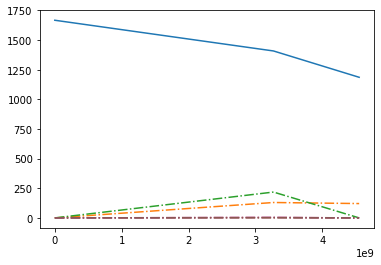

In [38]:
array_Ni = [N_i, N_i_2, N_i_3]
array_Nj = [N_j, N_j_2, N_j_3]
array_Nk = [0., N_k_1, N_k1_3]
array_Nij = [0., N_ij_3, 0.]
array_Nik = [0.,N_ik_3, 0.]
array_Njk = [0., N_jk_3, 0.]
array_Nkk = [0.,N_kk_3, 0.]
age_time = [0.,delta_t_1, delta_t_2.value]
pl.plot(age_time,array_Ni,"-")
#pl.plot(age_time,array_Nj,"-")
pl.plot(age_time,array_Nk,"-.")
pl.plot(age_time,array_Nij,"-.")
pl.plot(age_time,array_Nik,"-.")
pl.plot(age_time,array_Njk,"-.")
pl.plot(age_time,array_Nkk,"-.")